In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
# from tensorflow.keras import objectives
from scipy.stats import norm
from tensorflow.keras.losses import binary_crossentropy


(60000, 784) (10000, 784)
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 256)          200960      input_14[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 128)          32896       dense_56[0][0]                   
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 2)            258         dense_57[0][0]                   
_________________________________________________________________

60000/60000 [==============================] - 8s 141us/sample - loss: 153.5713 - val_loss: 152.3381
Epoch 5/10
60000/60000 [==============================] - 8s 139us/sample - loss: 150.6012 - val_loss: 150.1493
Epoch 6/10
60000/60000 [==============================] - 8s 136us/sample - loss: 148.5540 - val_loss: 148.4813
Epoch 7/10
60000/60000 [==============================] - 8s 141us/sample - loss: 146.9662 - val_loss: 146.9034
Epoch 8/10
60000/60000 [==============================] - 8s 139us/sample - loss: 145.6854 - val_loss: 145.7394
Epoch 9/10
60000/60000 [==============================] - 8s 138us/sample - loss: 144.5539 - val_loss: 145.1663
Epoch 10/10
60000/60000 [==============================] - 8s 142us/sample - loss: 143.6645 - val_loss: 143.7739
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 784)]             0         
__________

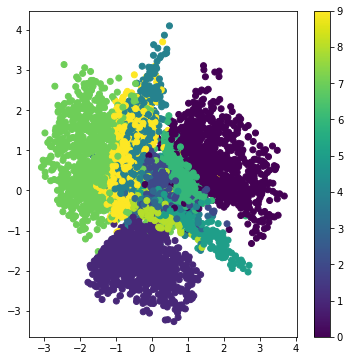

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_46 (Dense)             multiple                  384       
_________________________________________________________________
dense_47 (Dense)             multiple                  33024     
_________________________________________________________________
dense_48 (Dense)             multiple                  201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


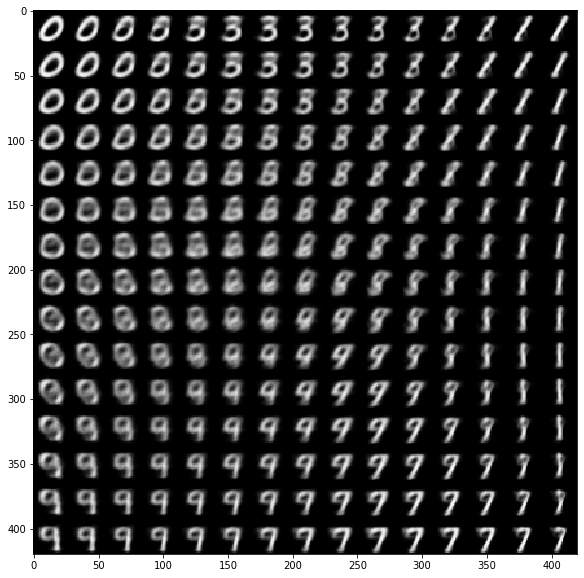

In [12]:

# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# network parameters
batch_size, n_epoch = 100, 10
n_hidden, z_dim = 256, 2

# encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)

# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])


# decoder
z_decoded = Dense(n_hidden//2, activation='relu')(z)
z_decoded = Dense(n_hidden, activation='relu')(z_decoded)
y = Dense(x_tr.shape[1], activation='sigmoid')(z_decoded)

# z_decoded = z_decoder1(z)
# z_decoded = z_decoder2(z_decoded)
# y = y_decoder(z_decoded)

# loss
reconstruction_loss = binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

# build model
vae = Model(x, y)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

# train
vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)


# build encoder
encoder = Model(x, mu)
encoder.summary()

# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()


# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

(60000, 784) (10000, 784)
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 256)          200960      input_10[0][0]                   
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 128)          32896       dense_42[0][0]                   
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 2)            258         dense_43[0][0]                   
_________________________________________________________________

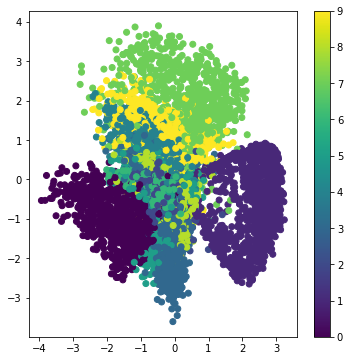

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_46 (Dense)             multiple                  384       
_________________________________________________________________
dense_47 (Dense)             multiple                  33024     
_________________________________________________________________
dense_48 (Dense)             multiple                  201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


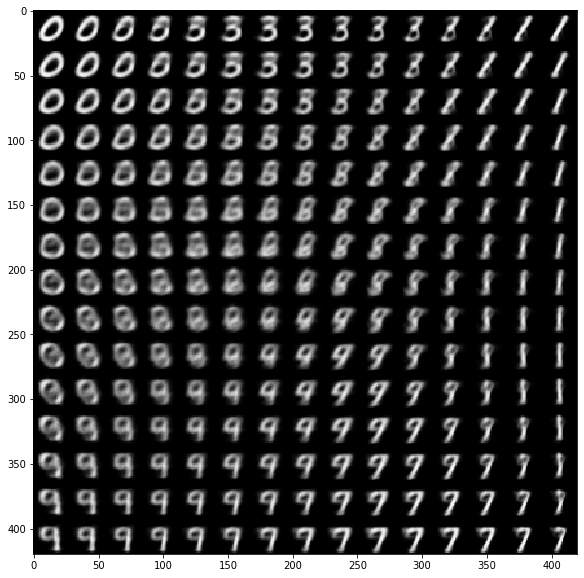

In [10]:

# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# network parameters
batch_size, n_epoch = 100, 2
n_hidden, z_dim = 256, 2

# encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)

# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

#--------------------------------------------------------------------------------------------------------------#
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)
#----------------------------------------------------------------------------------------------------------------#
# loss
reconstruction_loss = binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

# build model
vae = Model(x, y)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

# train
vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)


# build encoder
encoder = Model(x, mu)
encoder.summary()

# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()


# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()